# Feedback notes for programming Lotka-Volterra in  Python

## Introduction
The goal of the first assignment is to get you up to speed on
using Matlab or Python for solving differential equations. In my opinion it
is best to solve a differential equation by using a standard approach.
Python has several built in solvers for solving
ordinary differential equations. The first assignment is to implement
the Lotka Volterra approach using your own and the built in solvers. The Lotka
Volterra equations are a so-called predator prey model and describe
the following rates:

$$\frac{\mathrm{d}R}{\mathrm{d}t} = a R - b R F \\
\frac{\mathrm{d}F}{\mathrm{d}t} =  -c F + d R F$$


in which $R$ and $F$ are the two state variables (number of Rabbits
and Foxes). And $\alpha$, $\beta$, $\gamma$ and $\delta$ are the
growth and predation parameters. In order to use a general solver it is best to rewrite the problem in to the following equation:
$$ M(t,y)y'=f(t,y) $$
where $y'=\frac{\mathrm{d}y}{\mathrm{d}t}$ and $t$ is time and $M(t,y)$
is the so-called mass matrix. In the case of the Lotka-Volterra problem it is the identitymatrix. It is important to realise that Matlab and the numpy package are 
matrix based. This means that the user may assume that any variable
used can be a matrix, a vector or a scalar. It is up to the user to
program a the function $f(t,y)$ in such a way that it will perform
the correct type of calculations based on the type of variable passed
in $t$ and $y$. Given the fact that $y'$ and $y$ are related,
the structure of $y'$ should be the same as that of $y$. 


# Initialization of the code
The first thing we need to do in a Python code is to load the required packages so that we can solve our problem. In this case we will use a number of packages from the Scipy.org suite (https://www.scipy.org/). We start by loading the packages. Please note that MyTicToc is my own implementation of the tic toc functions of matlab so that we can time how long certain sections of code need to run.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
#import MyTicToc as mt

%matplotlib inline

In order to time the different solutions we need a timer. I made my own based on the approach used in Matlab (tic and toc)

In [2]:
def tic():
    #Homemade version of matlab tic and toc functions
    import time
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    import time
    if 'startTime_for_tictoc' in globals():
        print ("Elapsed time is " + str(time.time() - startTime_for_tictoc) + " seconds.")
    else:
        print ("Toc: start time not set")

In order to solve the problem we will need to call the rate equation several times. Therefore it is best to program a special class for this purpose. As mentioned above we use a vector notation to store the number of rabbits and foxes: $Y[0]=R$ and $Y[1] = F$.

In [3]:
# Definition of Rate Equation
def dYdt(t, Y):
    """ Return the growth rate of fox and rabbit populations. """
    return np.array([ a*Y[0] -   b*Y[0]*Y[1] ,
                     -c*Y[1] + d*Y[0]*Y[1] ])


In order to be able to solve the problem we require values for the parameters and we need an initial value for the number of rabbits and foxes in the system:

In [4]:
# Definition of parameters
a = 2.
b = 0.3
c = 0.1
d = 0.02

# Initial case, 10 rabbits, 5 foxes
Y0 = np.array([10, 5])


In order simulate the problem we need to tell the model over what time range the simulation has to be carried out. In this case we choose to run the model over 200 days. At the same time it is wise to specify at which times you want to record model output. As our implementation will use automatic time stepping, we specify the simulation time and the model output in one go.

In [5]:
# Definition of output times (0 to 200 days)
tOut = np.linspace(0, 100, 200)  
nOut = np.shape(tOut)[0]


## Solution using built in solver (odeint)

The SciPy package has several built-in solvers for ordinary differential equations. Perhaps the most easy to use class is odeint. You can easily find a lot of help just by googling. We pass our rate function $dYdt$ to the built-in class and as a result we obtain the soltuion for our output times in YODE. The best way to evaluate the results is to plot the results in a graph. 


Elapsed time is 0.024794816970825195 seconds.


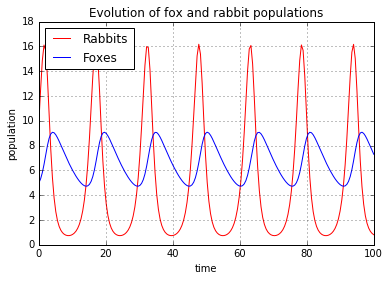

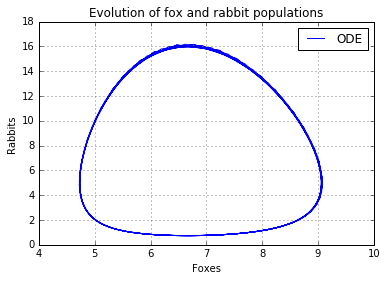

In [6]:
import scipy.integrate as spint

tic()
t_span = [tOut[0], tOut[-1]]
YODE = spint.solve_ivp(dYdt, t_span, Y0, t_eval=tOut, vectorized=True,
                      method='RK45', rtol=1e-5)
# infodict['message']                     # >>> 'Integration successful.'
rODE = YODE.y[0,:]
fODE = YODE.y[1,:]

toc()

plt.figure()
plt.plot(tOut, rODE, 'r-', label='Rabbits')
plt.plot(tOut, fODE  , 'b-', label='Foxes')

plt.grid()
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('population')
plt.title('Evolution of fox and rabbit populations')

# f1.savefig('rabbits_and_foxes_1.png')

plt.figure()
plt.plot(fODE, rODE, 'b-', label='ODE')
plt.grid()
plt.legend(loc='best')
plt.xlabel('Foxes')
plt.ylabel('Rabbits')
plt.title('Evolution of fox and rabbit populations')


## Solution using my own implementation based on Euler's approach

Eulers method is the most simple approach for numerically solving an ordinary differential equation. In order to guarantee a stable solution we need to ensure that the time step is not too large. We need to program an approach to control the time step size based on the calculated rates. In this case we want to have a maximum decrease in  states to be 70 % of the current value. 

Because we need to store output at the required output times we need to initialize an output vector. The time stepping needs to be initialized as well. The size of the time step is also controlled by the out put times, we need to make sure that the model calculates the states for all predefined output times.

Elapsed time is 0.029438495635986328 seconds.


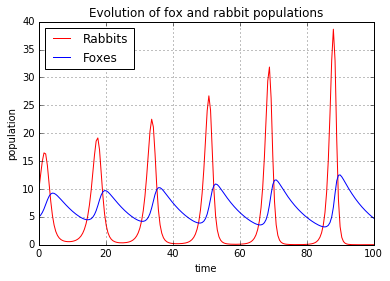

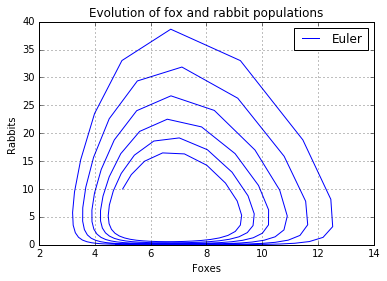

In [7]:
'''EULER'''

# Initialize output vector
YEuler = np.zeros([nOut,2],dtype = float)

dtMax = 0.1
t = tOut[0]
iiOut = 0

# Initialize problem
tic()
Y = Y0
# Write initial values to output vector
YEuler[iiOut,[0,1]] = Y
while (t < tOut[nOut-1]):
    # check time steps
    Rates = dYdt(t, Y)
    dtRate = -0.07 * Y/Rates
    dtRate = (dtRate < 0)*dtMax + (dtRate>=0)*dtRate  # We only need to take the positive rates in to account
    dtOut = tOut[iiOut+1]-t
    dt = min(min(dtRate),dtOut,dtMax)

    Y = Y + Rates * dt
    t = t + dt

    #print ("Time to Output is " + str(np.abs(tOut[iiOut+1]-t)) + " days.")

    if (np.abs(tOut[iiOut+1]-t)<1e-5) :
        YEuler[iiOut+1,[0,1]] = Y
        iiOut += 1

rEuler , fEuler = YEuler.T
toc()

plt.figure()
plt.plot(tOut, rEuler, 'r-', label='Rabbits')
plt.plot(tOut, fEuler  , 'b-', label='Foxes')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('population')
plt.title('Evolution of fox and rabbit populations')

plt.figure()
plt.plot(fEuler, rEuler, 'b-', label='Euler')
plt.grid()
plt.legend(loc='best')
plt.xlabel('Foxes')
plt.ylabel('Rabbits')
plt.title('Evolution of fox and rabbit populations')



Clearly this solution is unstable, as time progresses you will see that the solution eventually becomes unstable, even with the stability criterium. The time step has to be much smaller for a stable (first-order) approximation. You can improve the accuracy of the solution by reducing dtMax.

## Other easy to implement solutions (predictor-corrector and Runge-Kutta 4th order)

Following the template used for the Euler method we can easily expand the approach to predictor-corrector and the Runge Kutta fourth order approaches. These are more accurate that the Euler and with a similar time step criterion lead to much better solutions. This is because these solutions have higher order accuracies (2nd and 4th).

Elapsed time is 0.2910807132720947 seconds.
Elapsed time is 0.31331467628479004 seconds.


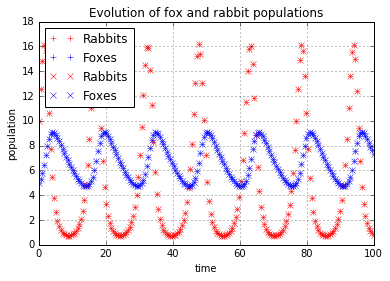

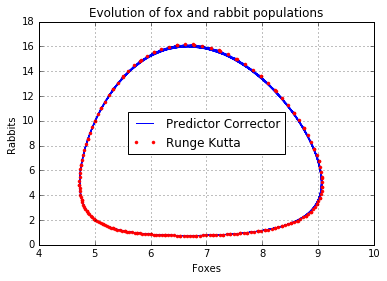

In [8]:
'''EULER Predictor Corrector'''

# Initialize output vector
YPC = np.zeros([nOut,2],dtype = float)

dtMax = 0.01
#dtMin = 1e-11
t = tOut[0]
iiOut = 0

# Initialize problem
tic()
Y = Y0
# Write initial values to output vector
YPC[iiOut,[0,1]] = Y
while (t < tOut[nOut-1]):
    # check time steps
    Rates = dYdt(t, Y)
    dtRate = -0.7 * Y/Rates
    dtRate = (dtRate < 0)*dtMax + (dtRate>=0)*dtRate  # We only need to take the positive rates in to account
    dtOut = tOut[iiOut+1]-t
    dt = min(min(dtRate),dtOut,dtMax)

    # Iteration with predictor corrector
    converged = False
    convCrit = 1e-6;
    Yn = Y + Rates * dt
    while not(converged):
        Rn = dYdt(t, Yn)
        Ynn = Y + (Rates + Rn)/2 * dt
        if max(np.abs(Yn-Ynn))<convCrit:
            converged = True
        else:
            Yn = Ynn

    Y = Yn
    t = t + dt
#print ("Time to Output is " + str(np.abs(tOut[iiOut+1]-t)) + " days.")

    if (np.abs(tOut[iiOut+1]-t)<1e-5) :
        YPC[iiOut+1,[0,1]] = Y
        iiOut += 1

rPC , fPC = YPC.T
toc()

'''RungeKutta'''
# Initialize output vector
YRK = np.zeros([nOut,2],dtype = float)
dtMax = 0.01
#dtMin = 1e-11
t = tOut[0]
iiOut = 0
# Initialize problem
tic()
Y = Y0
# Write initial values to output vector
YRK[iiOut,[0,1]] = Y
while (t < tOut[nOut-1]):
    # check time steps
    R1 = dYdt(t, Y)

    dtRate = -0.7 * Y/R1
    dtRate = (dtRate < 0)*dtMax + (dtRate>=0)*dtRate  # We only need to take the positive rates in to account
    dtOut = tOut[iiOut+1]-t
    dt = min(min(dtRate),dtOut,dtMax)

    k1 = dt*R1
    k2 = dt*dYdt(t+dt/2, Y+k1/2)
    k3 = dt*dYdt(t+dt/2, Y+k2/2)
    k4 = dt*dYdt(t+dt, Y+k3)

    Y = Y +  (k1 + 2*k2 + 2*k3 + k4) / 6
    t = t + dt

    #print ("Time to Output is " + str(np.abs(tOut[iiOut+1]-t)) + " days.")
    if (np.abs(tOut[iiOut+1]-t)<1e-5) :
        YRK[iiOut+1,[0,1]] = Y
        iiOut += 1

rRK , fRK = YRK.T
toc()

plt.figure()
plt.plot(tOut, rPC, 'r+', label='Rabbits')
plt.plot(tOut, fPC, 'b+', label='Foxes')
plt.plot(tOut, rRK, 'rx', label='Rabbits')
plt.plot(tOut, fRK, 'bx', label='Foxes')
plt.grid()
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('population')
plt.title('Evolution of fox and rabbit populations')

plt.figure()
plt.plot(fPC, rPC, 'b-', label='Predictor Corrector')
plt.plot(fRK, rRK, 'r.', label='Runge Kutta')

plt.grid()
plt.legend(loc='best')
plt.xlabel('Foxes')
plt.ylabel('Rabbits')
plt.title('Evolution of fox and rabbit populations')
